In [1]:
using NBInclude
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"));

# Initial Parameters

In [2]:
Nx = 8; Ny = 10; N=Nx*Ny; p = 1; q = Ny; cut_off = Nx;
PN = [0,1,2,3];
U = 2;
print("Magnetic flux per unit-cell:",p/q,"\n Number of flux quanta:",Nx)

Magnetic flux per unit-cell:0.1
 Number of flux quanta:8

# Single-Particle

In [3]:
@doc get_sp_op

Compute the single-particle operator from single-particle matrix.

#### Arguments

  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `N::Integer`: The total site number.
  * `sp_matrix::Matrix`: Hopping phases matrix from any model.


In [4]:
sp_basis = NLevelBasis(N)
periodicity = 0
sp_matrix = Hofstadter_SP(Nx, Ny, p/q, periodicity);

In [5]:
H1 = get_sp_op(sp_basis, N, sp_matrix);

In [6]:
using LinearAlgebra
eigenenergies(dense(H1)) == eigvals(sp_matrix) # true
#show(stdout, "text/plain", eigvals(sp_matrix))

true

In [7]:
@doc get_sub_states

Compute the first eigen-states in a given number.

#### Arguments

  * `sp_op::get_sp_op`: Single-particle operator.
  * `cut_off::Int`: Limit value of eigen-state index.


In [8]:
sub_states = get_sub_states(H1, cut_off);

In [9]:
@doc get_projector_op

Compute sub-space basis, projection and comlex conjugate of projection operator.

#### Arguments

  * `states::get_sub_states`: Eigen-states of the sub-space.
  * `basis::NLevelBasis`: Single-particle basis.


In [10]:
basis_sub, P, Pt = get_projector_op(sub_states, sp_basis);

In [11]:
@doc get_subspace_op

Compute the corresponding operator in the sub-space.

#### Arguments

  * `sp_op::Operator`: Single-particle operator from single-particle matrix.
  * `P::get_projector_op[2]`: Projection operator.
  * `Pt::get_projector_op[3]`: Complex conjugate of projection operator.


In [12]:
H1_sub = get_subspace_op(H1, P, Pt);

In [13]:
@doc get_num_sub_list

Compute the single-particle number operator for each lattice sites.

#### Arguments

  * `N::Integer`: The total site number.
  * `sp_basis::NLevelBasis`: Single-Particle basis.
  * `P::get_projector_op[2]`: Projection operator.
  * `Pt::get_projector_op[3]`: Complex conjugate of projection operator.


In [14]:
num_sub_list = get_num_sub_list(N, sp_basis, P, Pt);

# Many-Body

In [15]:
@doc get_mb_op

Compute the many-body operator for boson particles from single-particle operator.

#### Arguments

  * `basis_mb`: Many-body basis.
  * `basis_sub::get_projector_op[1]`: Sub-space basis.
  * `sp_op::Operator`: Single-particle operator from single-particle matrix.


In [16]:
states_mb = bosonstates(basis_sub, PN) 
basis_mb = ManyBodyBasis(basis_sub, states_mb);

In [17]:
H1_MB = get_mb_op(basis_mb, basis_sub, H1_sub);

In [18]:
# states_mb = bosonstates(b_sub, PN) 
# basis_mb = ManyBodyBasis(b_sub, states_mb)

In [19]:
# H1_MB = get_mb_op(basis_mb, b_sub, H1_sub);

In [20]:
# @doc get_num_mb_list

In [21]:
# num_mb_list = get_num_mb_list(basis_mb, b_sub, num_sub_list);

In [22]:
@nbinclude("Hofstadter MB in Julia.ipynb"; regex=r"#.*executeme")

Hofstadter_Finite_U (generic function with 1 method)

In [23]:
@doc Hubbard_Interaction

Compute the on-site Bose-Hubbard Interaction term.

#### Arguments:

  * `basis_cut_sp`: The cutt-off sites of bosonic many-body basis.
  * `basis_cut_mb`: The cutt-off sites of single-particle basis.
  * `P::Operator`: Projection operator.
  * `Pt::Operator`: Complex conjugate of projection operator.
  * `cut_off::Int`: Limit value of eigen-state index.


In [24]:
#bcut_mb, bcut = get_Bosonic_MB_Basis(cut_off,PN)
basis_cut_mb, basis_cut_sp = get_Bosonic_MB_Basis(cut_off,PN)
H_Int = Hubbard_Interaction(basis_cut_sp, basis_cut_mb, P, Pt, cut_off);

# Constructing Total Hamiltonians 

In [58]:
H1cut = SparseOperator(basis_cut_mb)
H1cut.data = H1_MB.data

number_mb_list_operators = get_num_mb_op(N, basis_cut_sp, num_sub_list, basis_cut_mb, basis_sub)

function get_total_H(V, imp_site, number_mb_list_operators, H1cut, H_Int)
    V_imp = V * number_mb_list_operators[imp_site]
    H_totall = H1cut + H_Int + V_imp
    return H_totall
end
imp_site = 45
H_total_imp = get_total_H(4, imp_site, number_mb_list_operators, H1cut, H_Int)
H_total = get_total_H(0, 45, number_mb_list_operators, H1cut, H_Int);

# Exact-Diagonalization

In [59]:
using DataFrames

E, V = eigenstates(dense((H_total_imp+dagger(H_total_imp))/2))
E0, V0 = eigenstates(dense((H_total+dagger(H_total))/2))

function get_energies(pn, E, V, basis)
    PN_Energies = Array{Float64}(undef, length(E), 2)
    for i in 1:length(E)
        PN_Energies[i] = round(expect(number(basis), V[i])) #expected values (first column)
        PN_Energies[i,2] = E[i] #eigen-values (second column)
    end
    
    # filter
    df = DataFrame(PN_Energies, :auto)
    df = filter(row -> (row.x1 == pn),  df)
    
    return df
end

get_energies (generic function with 1 method)

In [60]:
PN

4-element Vector{Int64}:
 0
 1
 2
 3

In [61]:
pn = 3.0
df = get_energies(pn, E, V, basis_cut_mb)
df_0 = get_energies(pn, E0, V0, basis_cut_mb)
filtered_energies = Matrix(df)[:,2]
#filtered_energies_0 = Matrix(df_0)[:,2]
#show(stdout,"text/plain", filtered_energies) #show all outputs

120-element Vector{Float64}:
 -10.25989036827856
 -10.259884355536734
 -10.259864512378334
 -10.25985088435604
 -10.259839167727383
 -10.259824249734958
 -10.259823526897181
 -10.222086796366424
 -10.222016263190625
 -10.219513235302074
 -10.217732415278812
 -10.199841575511721
 -10.1964634812048
   ⋮
  -9.65120498916236
  -9.646553983805251
  -9.625829451051366
  -9.621949132365057
  -9.357538317049935
  -9.349522601020238
  -9.34758869155075
  -9.317961495391943
  -9.301453804822799
  -9.241709143692601
  -9.159917826968924
  -8.75863103565573

In [62]:
using Plots
plot(1:35,E0,seriestype=:scatter,xlabel="n",ylabel="E",legend=false)
title!("Nx=$(Nx),Ny=$(Ny),Phi=$(round(p/q,digits = 3)),N_phi=$(Nx),nu=$(pn/Nx), \n V_imp=0")
#ylims!((-7.20544,-7.20536)) # Onur hocanın makalesinde ki FIG1 için sınırlar

LoadError: MethodError: no method matching /(::Plots.Plot{Plots.GRBackend}, ::Int64)

Some of the types have been truncated in the stacktrace for improved reading. To emit complete information
in the stack trace, evaluate `TruncatedStacktraces.VERBOSE[] = true` and re-run the code.

[0mClosest candidates are:
[0m  /([91m::Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}[39m, ::Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}) at int.jl:97
[0m  /([91m::StridedArray{P}[39m, ::Real) where P<:Dates.Period at C:\Users\Can\AppData\Local\Programs\julia-1.8.1\share\julia\stdlib\v1.8\Dates\src\deprecated.jl:44
[0m  /([91m::Union{SparseArrays.SparseVector{Tv, Ti}, SubArray{Tv, 1, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, false}, SubArray{Tv, 1, <:SparseArrays.AbstractSparseVector{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}}, false}} where {Tv, Ti}[39m, ::Number) at C:\Users\Can\AppData\Local\Programs\julia-1.8.1\share\julia\stdlib\v1.8\SparseArrays\src\sparsevector.jl:1506
[0m  ...

Allta ki fonksiyonun çalışması için, dizide ki filtre edilmiş parçacık sayısı her zaman en büyük değer de olmalıdır.
Örneğin, `PN=[0,1,2,3,4]` iken filtre edilen parçacık sayısı `pn=4` olmalıdır!

In [63]:
function Restricted_Hubbard_States(states)
    number_of_states = length(filtered_energies)
    return states[1:number_of_states];
end

Restricted_Hubbard_States (generic function with 1 method)

In [64]:
r_hubbard_states = Restricted_Hubbard_States(V);
r_hubbard_states_0 = Restricted_Hubbard_States(V0);

# Density Profile

In [65]:
# METHOD 1

NM_MB_Array_Storage = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb),N);
NM_MB_Matrix = zeros(Complex{Float64},length(basis_cut_mb),length(basis_cut_mb));
for m in 1:N
    for i in 1:length(basis_cut_mb)
        for j in 1:length(basis_cut_mb)
            #NM_MB_Matrix[i,j] = num_mb_list[m].data[i,j]
            NM_MB_Matrix[i,j] = number_mb_list_operators[m].data[i,j]
            # NOT: num_mb_list ile number_mb_list_operators bazları farklı ama içerikleri aynı!
        end
    end
    NM_MB_Array_Storage[:,:,m] = NM_MB_Matrix
end

BL = BR = basis_cut_mb
index_number_op = 4
T = NM_MB_Array_Storage[:,:,index_number_op]
Op = Operator(BL,BR,T)
index_eigen_states = 1
expect(Op, r_hubbard_states[index_eigen_states])
expect(Op, r_hubbard_states_0[index_eigen_states])

#or
# expect(number_mb_list_operators[index_number_op],r_hubbard_states[index_eigen_states])

0.056147989239729724 - 4.389882615309532e-19im

In [66]:
function get_total_density_profiles(NM_MB_Array_Storage, r_hubbard_states)
    Sum = 0
    total_expect_list=[]
    for i in 1:N
        T = NM_MB_Array_Storage[:,:,i]
        Op = Operator(BL,BR,T)
        n_i = 0
        for index_eig_states in 1:q        
            Sum += expect(Op, r_hubbard_states[index_eig_states])
            n_i += expect(Op, r_hubbard_states[index_eig_states])
        end
        push!(total_expect_list, n_i)
    end
    return real(total_expect_list)
end
get_total_density_profiles(NM_MB_Array_Storage, r_hubbard_states)

80-element Vector{Float64}:
 0.38499346137835877
 0.38594473772400073
 0.38849548768378034
 0.3925486371191565
 0.3901885497591563
 0.392548637119154
 0.3884954876837778
 0.3859447377239976
 0.37921784939000897
 0.3825630901895495
 0.3902374136307652
 0.39809742631820516
 0.39734840214707073
 ⋮
 0.4072571473751653
 0.409342290860402
 0.39820957274342805
 0.3796736246785404
 0.37921784939002084
 0.38256309018956697
 0.39023741363078984
 0.39809742631823153
 0.39734840214709977
 0.39809742631823136
 0.3902374136307867
 0.3825630901895643

In [67]:
index_eig_states = 10
function get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states)
    Sum = 0
    expect_list=[]
    for i in 1:N
        T = NM_MB_Array_Storage[:,:,i]
        Op = Operator(BL,BR,T)      
        Sum += expect(Op, r_hubbard_states[index_eig_states])
        push!(expect_list,expect(Op, r_hubbard_states[index_eig_states]))
    end
    return real(expect_list)
end
get_density_profiles(NM_MB_Array_Storage,r_hubbard_states, index_eig_states)

80-element Vector{Float64}:
 0.07499946326714067
 0.06599132633529727
 0.04839895642134013
 0.036432916030162944
 0.02931107784168929
 0.036432916030173707
 0.048398956421361904
 0.06599132633531614
 0.048372497322715466
 0.042487194020377185
 0.0313821391506175
 0.02521059581497256
 0.021007999145893286
 ⋮
 0.033057196814755205
 0.03056997049784432
 0.02183545946580974
 0.01697237615797527
 0.04837249732273296
 0.042487194020385866
 0.031382139150616474
 0.02521059581496655
 0.02100799914588868
 0.025210595814978785
 0.031382139150639594
 0.04248719402040535

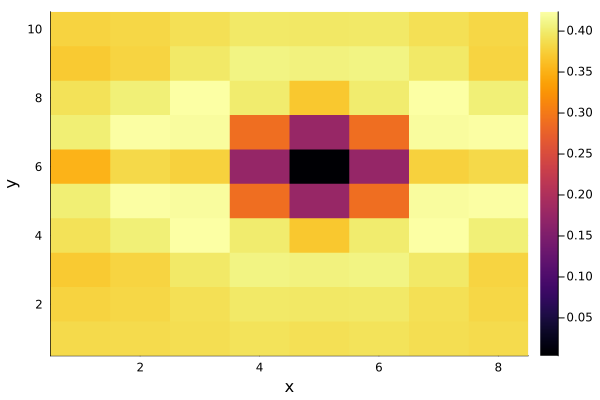

In [121]:
heatmap(reshape(get_total_density_profiles(NM_MB_Array_Storage, r_hubbard_states), Nx, Ny)|> transpose,interpolate=true, xlabel="x", ylabel="y")

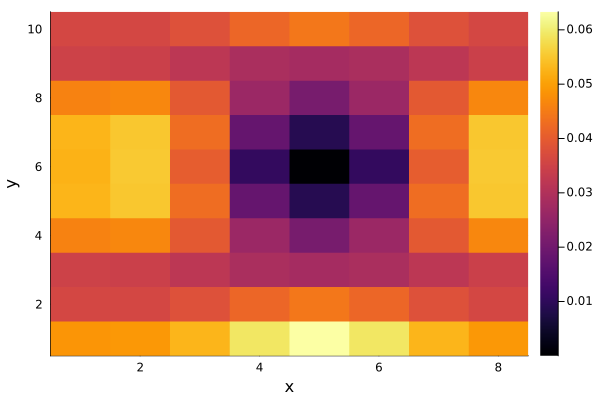

In [122]:
heatmap(reshape(get_density_profiles(NM_MB_Array_Storage, r_hubbard_states, index_eig_states), Nx, Ny)|> transpose,xlabel="x", ylabel="y")

In [37]:
using Interpolations

function Interp2D(data, factor)
    
    IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)

    finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
    finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
    nx = length(finerx)
    ny = length(finery)

    data_interp = Array{Float64}(undef,nx,ny)
    for i ∈ 1:nx, j ∈ 1:ny
        data_interp[i,j] = IC(finerx[i],finery[j])
    end

    return finerx, finery, data_interp

end  

Interp2D (generic function with 1 method)

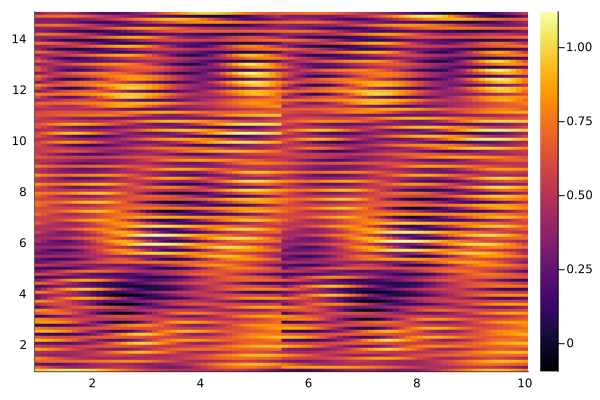

In [38]:
# Test
data = rand(10,15)

# Simple heatmap
heatmap(data)      

# Heatmap of Interpolated data            
heatmap(Interp2D(data, 8))   

In [40]:
# Keyfi \rho yarıçapları içerisine kalan site'lardan toplam almam lazım.+
# Yarıçap verip, o yarıçap içerisindeki site'ları belirlemem lazım. +
# Site'ları belirledikten sonra density hesaplanır +

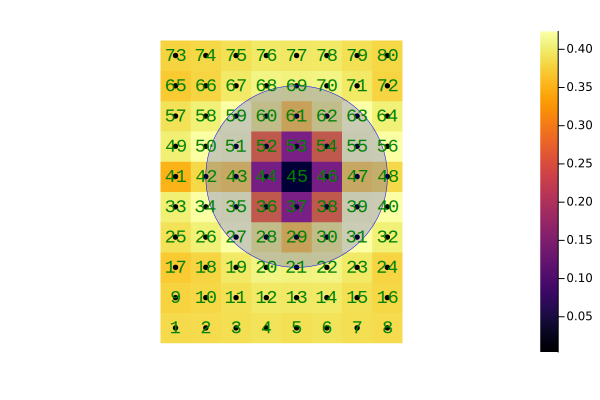

get_inner_sites (generic function with 1 method)

In [162]:
heatmap(reshape(get_total_density_profiles(NM_MB_Array_Storage, r_hubbard_states), Nx, Ny)|> transpose,interpolate=true)

# koordinatları 0 yerine 1'den başlatırsak heatmap ile uyumlu olur (.+1 operasyonu)
x_coordinates = square_lattice(Nx,Ny)[2][:,1] .+ 1
y_coordinates = square_lattice(Nx,Ny)[2][:,2] .+ 1
scatter!(x_coordinates,y_coordinates,label=false, aspect_ratio=1, showaxis = false, grid=false, markersize=3, c=:black)

center_x = x_coordinates[imp_site]; center_y = y_coordinates[imp_site]; radius = 3;
for i in 1:N
    p = annotate!(x_coordinates[i], y_coordinates[i], text("$i", :Courier, 10,:green), :color)    
end

function circle_shape(h,k,r)
    beta = LinRange(0, 2*pi, 500)
    h .+ r*sin.(beta), k .+ r*cos.(beta)
end

plot!(circle_shape(center_x,center_y,radius), seriestype=[:shape], lw=0.5, c=:blue, linecolor= :blue, legend=false, fillalpha=0.2)

display(p)

function get_inner_sites(radius)
    inner_sites = []
    # Hangi site'lar yarı-çapı verilmiş daire içerisinde kontrol et
    for i in 1:N
        if (x_coordinates[i] - center_x)^2 + (y_coordinates[i] - center_y)^2 < radius^2
            push!(inner_sites, i)
        end
    end
    return inner_sites
end

In [172]:
get_inner_sites(3)

25-element Vector{Any}:
 27
 28
 29
 30
 31
 35
 36
 37
 38
 39
 43
 44
 45
 46
 47
 51
 52
 53
 54
 55
 59
 60
 61
 62
 63

$\mathcal{Q}_\rho = \sum_i \left( <n_i>_{V\neq0} - <n_i>_{V=0} \right)$

In [170]:
index_eig_states = 1
Q_rho = 0
rr = 3
for i in get_inner_sites(rr)
    T = NM_MB_Array_Storage[:,:,i]
    Op = Operator(BL,BR,T)
    Q_rho += real(expect(Op, r_hubbard_states_0[index_eig_states]) - expect(Op, r_hubbard_states[index_eig_states]))
end
print("Radius=$(rr) => Q_rho= ",Q_rho)

Radius=3 => Q_rho= 0.48839603831922185

# Animation

In [44]:
# animated_exp_list = zeros(N,1,length(r_hubbard_states))
# function animated_e_l()
#     for i in 1:length(r_hubbard_states)
#         expect_list=[]
#         for j in 1:N
#             T = NM_MB_Array_Storage[:,:,j]
#             Op = Operator(BL,BR,T)
#             push!(expect_list,expect(Op, r_hubbard_states[i]))
#         end
#         animated_exp_list[:,:,i] = real(expect_list)
#     end
#     return animated_exp_list
# end

In [45]:
# k = 1
# initial_condition = reshape(animated_e_l()[:,:,k], Nx, Ny) #psi_1 (psi_k)'e karşılık gelen density matrix
# heatmap(initial_condition)

In [46]:
# initial_condition = reshape(animated_e_l()[:,:,1], Nx, Ny)
# fps = 20
# function heatgif(initial_condition)
#     p = heatmap(initial_condition, xlabel="x", ylabel="y", title=("Nx=$Nx,Ny=$Ny,co=$cut_off,PN=$pn,U=$U, fps=$fps"))
#     anim = @animate for i=1:length(r_hubbard_states)
#         h_map_matrix = reshape(animated_e_l()[:,:,i],Nx,Ny)
#         heatmap!(p[1], h_map_matrix)
#     end
#     return anim
# end

In [47]:
# anim = heatgif(initial_condition)
# gif(anim, "OUTPUT.gif", fps=fps)